# Генерация текста с помощью RNN


(по мотивам [семинара](https://github.com/neychev/harbour_dlia2019/blob/master/day02_Simple_RNN/Day_2_Simple_RNN_pytorch.ipynb)
 [курса "Deep Learning in Applications"](https://in.harbour.space/data-science/deep-learning-in-applications-radoslav-neychev-anastasia-ianina/))

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Данные
Датасет содержит ~9k имен, все написаны латиницей.

In [27]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('datasets/russian_names.txt') as input_file:
    names = input_file.read()[:-1].split('\n')
    names = [' ' + line for line in names]

In [28]:
names[:5]

[' Ababko', ' Abaev', ' Abagyan', ' Abaidulin', ' Abaidullin']

In [29]:
len(names)

9408

Посмотрим на распределение длин имен:

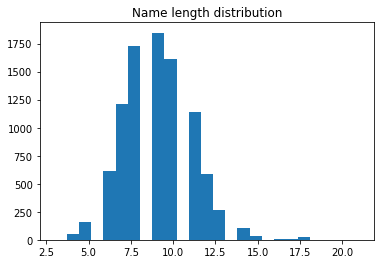

In [30]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=25);

# Препроцессинг

In [31]:
#all unique characters go here
tokens = list(set(''.join(names)))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  52


### Символы -> id

Создадим словарь < символ > -> < id >

In [32]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [33]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [2]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [35]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000], token_to_id))

 Ababko
 Chihachev
 Isaikov
 Nakhamkin
 Ustenko
[[ 5  4 24 21 24 42 36  5  5  5]
 [ 5 45  7  6  7 21 49  7 34 19]
 [ 5 50 27 21  6 42 36 19  5  5]
 [ 5 51 21 42  7 21 17 42  6 18]
 [ 5 13 27  2 34 18 42 36  5  5]]


# Рекуррентные нейронные сети

<img src="img/rnn.png" width=480>

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from IPython.display import clear_output
from random import sample

In [200]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [163]:
a = torch.tensor([[1,2],
        [3, 4]])

b = torch.tensor([[5, 6],
        [7, 8]])

torch.cat([a,b], dim=1)

tensor([[1, 2, 5, 6],
        [3, 4, 7, 8]])

In [201]:
char_rnn = CharRNNCell()

### Тренировка сети, RNN loop

In [202]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        print(x_t.shape, hid_state.shape)
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

### Тренировка сети

In [9]:


char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

NameError: name 'CharRNNCell' is not defined

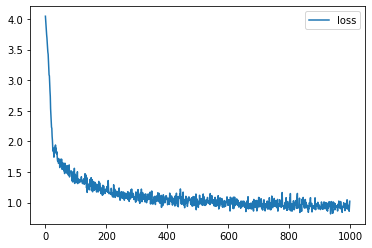

In [204]:
MAX_LENGTH = max(map(len, names))
batch_size = 32

for i in range(1000):
    batch_ix = to_matrix(sample(names, batch_size), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: генерация имен

In [205]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [209]:
for _ in range(10):
    print(generate_sample(char_rnn))

 Jazhonov            
 Jarichetilov        
 Btohev              
 Merdche             
 Alodovsky           
 Grugukov            
 Batsk-in            
 Vatogotin           
 Vlatcherov          
 Bakhnukov           


In [219]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' Moroz'))

 Morozuk             
 Morozhovo           
 Morozan             
 Morozov             
 Morozaev            
 Morozlin            
 Morozev             
 Morozov             
 Morozyr             
 Morozen             


### Более простое решение

* `nn.RNNCell(emb_size, rnn_num_units)` - шаг RNN. Алгоритм: concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - весь rnn_loop.

Кроме того, в PyTorch есть `nn.LSTMCell`, `nn.LSTM`, `nn.GRUCell`, `nn.GRU`, etc. etc.

Перепишем наш пример с генерацией имен с помощью средств PyTorch.

In [37]:
batch_size = 32
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.rnn_num_units = rnn_num_units
        
    def forward(self, x, hidden_state=None):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        if hidden_state is not None:
            h_seq, new_hidden = self.rnn(self.emb(x), hidden_state)
        else:
            h_seq, new_hidden = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, new_hidden
    def init_hidden(self):
        #Initialize hidden and cell states
        #(num_layers*num_directions,batch,hidden_size)
        return Variable(torch.zeros(1,batch_size,self.rnn_num_units))
    
rnn_num_units = 64 
model = CharRNNLoop(rnn_num_units=rnn_num_units)
opt = torch.optim.Adam(model.parameters())
history = []

In [38]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = Variable(torch.zeros(1, batch_size, rnn_num_units))
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        x_t = x_t.view(x_t.shape[0], 1)
        logp_next, hid_state = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

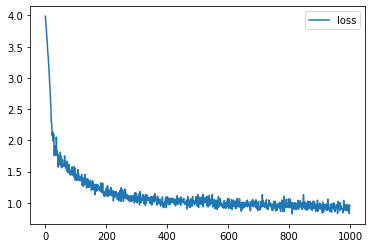

In [39]:
MAX_LENGTH = max(map(len, names))

for i in range(1000):
    batch_ix = to_matrix(sample(names, batch_size), token_to_id, max_len=MAX_LENGTH)
    batch_ix = Variable(torch.LongTensor(batch_ix))
    logp_seq, hidden = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [44]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [[token_to_id[token] for token in seed_phrase]]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hidden_s = None
    for i in range(len(seed_phrase) - 1):
        _, hidden_s = model.forward(x_sequence[:, :, i], hidden_s)
    
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hidden_s = model.forward(x_sequence[:, :, -1], hidden_s)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence[0, 0].data.numpy()])


for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=0.9))

 Hazzgin             
 Comikov             
 Babjmuk             
 Ragetsky            
 Polinorin           
 Pizire              
 Tototsanov          
 Yabedo              
 Gyevtdin            
 Oamrikov            


### Домашнее задание: мотивационные лозунги RNN

In [4]:
file = 'task4/data/quotes.txt'

import chardet    
rawdata = open(file, "br").read()
result = chardet.detect(rawdata)
charenc = result['encoding']


with open(file, 'r', encoding=charenc) as input_file:
    quotes = input_file.read().split('\n')
    quotes = [' ' + line.strip() for line in quotes]

In [5]:
tokens = list(set(''.join(quotes)))
tokens.extend(['\xa0'])
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)

In [70]:
quotes[:5]

[' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 " Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 ' Did you ever stop to think, and forget to start again?',
 ' Organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 ' Weeds are flowers too, once you get to know them.']

In [ ]:
tokens

In [48]:
len(quotes)

36166

In [49]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(quotes[::2000]))
print(to_matrix(quotes[::2000], token_to_id))

 If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
 In the beginning, everybody that gets to work with me, thinks I'm nice. But three weeks later, they hear a bell ringing. Then they realise I meant everything I said during that first week. It's not my fault people are not taking me serious from the first moment.
 I tend to get comfortable with the dialogue and find out who the person is in the script and try to hit that. People are sort of independent of their occupations and their pastimes. You don't play a politician or a fireman or a cowboy - you just play a person.
 'Tis love that makes the world go round, my baby.
 Some of these kids just don't plain know how good they are: how smart and how much they have to say. You can tell them. You can shine that light on them, one human interaction at a time.
 I was able to realize that I definitely want to make sure that I use my voice, as it gets bigger and bigger, in the world 

In [50]:
quotes[:5]

[' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 " Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 ' Did you ever stop to think, and forget to start again?',
 ' Organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 ' Weeds are flowers too, once you get to know them.']

In [86]:
batch_size = 32
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.rnn_num_units = rnn_num_units
        
    def forward(self, x, hidden_state=None):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        if hidden_state is not None:
            h_seq, new_hidden = self.rnn(self.emb(x), hidden_state)
        else:
            h_seq, new_hidden = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, new_hidden
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(1, batch_size, self.rnn_num_units).zero_()
        return hidden

In [91]:
rnn_num_units = 64 
model = CharRNNLoop(rnn_num_units=rnn_num_units)
opt = torch.optim.Adam(model.parameters())
history = []

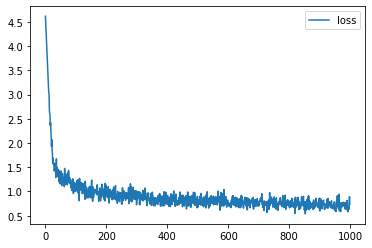

In [92]:
MAX_LENGTH = max(map(len, quotes))

for i in range(1000):
    batch_ix = to_matrix(sample(quotes, batch_size), token_to_id, max_len=MAX_LENGTH)
    batch_ix = Variable(torch.LongTensor(batch_ix))
    
    logp_seq, hidden = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [93]:
def generate_sample(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [[token_to_id[token] for token in seed_phrase]]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hidden_s = None
    for i in range(len(seed_phrase) - 1):
        _, hidden_s = model.forward(x_sequence[:, :, i], hidden_s)
    
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hidden_s = model.forward(x_sequence[:, :, -1], hidden_s)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence[0, 0].data.numpy()])


for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=0.9))

 I themce wast the more a mowmofe wing the me bur biont engof on ther ins chat woug  sonr fo bound,  fut houl amcaalon'He a an raty ende.                                                                                                                                                                                                                                                                                
 Thise tarlint ficf on hatiengor hang sone fay'He and in thars prean to pone woult whe gor the tar lofe senac bioing to of sisfes whep il sedasily say. Tre and dronces and and samy moldepchpen.'                                                                                                                                                                                                                       
 Then.                                                                                                                                                                              

# Домашнее задание: мотивационные лозунги LSTM

In [6]:
class CharLSTM(nn.Module):
    def __init__(self, num_tokens, emb_size=16, n_hidden=300, drop_prob=0.5, n_layers=2):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size=n_hidden, num_layers=n_layers,
                            dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.hid_to_logits = nn.Linear(n_hidden, num_tokens)

        self.n_layers = n_layers
        self.n_hidden = n_hidden

    def forward(self, x, hidden=None):
        # assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        ## TODO: Get the outputs and the new hidden state from the lstm
        x = self.emb(x)
        #         print(x.shape)
        if hidden is None:
            r_output, hidden = self.lstm(x)
        else:
            r_output, hidden = self.lstm(x, hidden)

        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)

        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
#         out = out.contiguous().view(-1, self.n_hidden)

        ## TODO: put x through the fully-connected layer
        next_logits = self.hid_to_logits(out)
        next_logp = F.log_softmax(next_logits, dim=-1)

        # return the final output and the hidden state
        return next_logp, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (torch.cuda.is_available()):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())

        return hidden

In [8]:
torch.cuda.is_available()

False

In [125]:
# rnn_num_units = 64 
model = CharLSTM(num_tokens, emb_size=500, drop_prob=0.2, n_hidden=300, n_layers=3)
opt = torch.optim.Adam(model.parameters())
history = []

In [126]:
MAX_LENGTH = max(map(len, quotes))
model.train()
model.cuda()
for i in range(2000):
    batch_ix = to_matrix(sample(quotes, batch_size), token_to_id, max_len=MAX_LENGTH)
    batch_ix = Variable(torch.LongTensor(batch_ix)).cuda()
    
#     h=model.init_hidden()
#     h = h.data
#     logp_seq, hidden = model(batch_ix, h)
    logp_seq, hidden = model(batch_ix)
#     print(logp_seq.shape)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

RuntimeError: CUDA error: unspecified launch failure

In [124]:
def generate_sample(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    model.eval().cpu()
    x_sequence = [[token_to_id[token] for token in seed_phrase]]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hidden_s = None
    for i in range(len(seed_phrase) - 1):
        _, hidden_s = model.forward(x_sequence[:, :, i], hidden_s)
    
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hidden_s = model.forward(x_sequence[:, :, -1], hidden_s)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence[0, 0].data.numpy()])


for _ in range(10):
    print(generate_sample(model, seed_phrase=' ', temperature=0.9))

 The old of money or not, none, we are when goon of the Nant who has been so many people who think cut more, every man in hard to change successful at others.                                                                                                                                                                                                                                                           
 I hope that I'm not to carriage that was the mouth view of 'Oather, it's going to be a loster character as God, it's like words, so much like a policy can problem can, over or life, because they wore in a commitment and shall think.                                                                                                                                                                                
 Kall of the star stars the quite when you air isn't investment.                                                                                                                    

### Что еще можно генерировать?
С помощью кода из этого семинара можно генерировать не только имена, но и:

* Повести/романы/поэзию/песни любимого автора
* Новостные заголовки
* Программный код
* Молекулы в формате [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
* Музыку
* Названия мебели из ИКЕА
* Мотивационные лозунги
* etc.

__Удачи!__